In [3]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# nltk 
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

#wordcloud
from wordcloud import WordCloud, STOPWORDS

import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Data Gathering

In [4]:
# read in the data
df =pd.read_csv("judge-1377884607_tweet_product_company.csv",encoding="'ISO-8859-1'")
df.head()
# encoding type from: https://stackoverflow.com/questions/21504319/python-3-csv-file-giving-unicodedecodeerror-utf-8-codec-cant-decode-byte-err

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# rename the columns 
df = df.rename(columns={"tweet_text":"tweet","emotion_in_tweet_is_directed_at":"product",
                        "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
df.tail()

,tweet,product,sentiment
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


#### The data has 9093 rows and 3 columns(Tweet, product and Sentiment). All 3 columns are of object type
 * tweet column has 1 null value
 * product column has 5802 null values
 * sentiment column does not have any null values

In [7]:
# check for duplicate tweet
df["tweet"].duplicated().sum()

27

#### There are 27 duplicate rows in the data

In [8]:
#drop duplicated tweet
df.drop_duplicates(subset= ["tweet"],inplace=True)

#### Removing the null values from tweet columns

In [9]:
# drop the null in Tweet
df= df.dropna(subset= ["tweet"])

In [10]:
df= df.reset_index(drop=True)

## Data Cleaning

#### Clean the data to remove:
 * special characters such as (@,*,&)
 * Punctuations
 * Numbers
 * Usernames
 * short words of length 1
 

In [11]:
#Taking a copy of our original DataFrame
test1=df.copy()

#### converting all the data to lower case for uniformity

In [12]:
test1=test1.apply(lambda x:x.astype(str).str.lower())

In [13]:
#replace all the non-alphabetic elements with 1
test1["tweet"]=test1["tweet"].apply(lambda x:  re.sub("[^A-za-z.!+ ]", '1', x))

#Filter all the non-alphabetic words
test1["tweet"]=test1["tweet"].apply(lambda x: " ".join(w for w in wordpunct_tokenize(x.strip()) if (w.isalpha())))


In [14]:
#checking the cleaned data
test1.head()

,tweet,product,sentiment
0,i have a iphone after hrs tweeting at it was d...,iphone,negative emotion
1,know about awesome app that likely appreciate ...,ipad or iphone app,positive emotion
2,can not wait for also they should sale them do...,ipad,positive emotion
3,i hope this festival as crashy as this iphone app,ipad or iphone app,negative emotion
4,great stuff on fri marissa mayer tim matt mull...,google,positive emotion


#### As seen from the table above, the data is clean and does not contain any symbols, punctuations, numbers or username

## Data Visualization

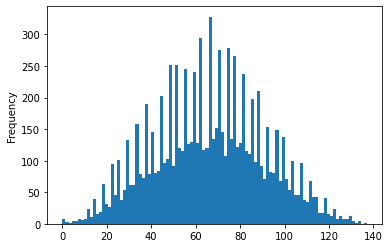

In [15]:
# plot the length of the tweet
test1['length']= test1['tweet']. apply(len)
test1['length'].plot(bins=100, kind='hist');
#the avarage length of the tweet between 90 to 110, min around 25, max around 175

 * Check how the data is distributed in different columns

In [16]:
test1["sentiment"].value_counts()

no emotion toward brand or product    5372
positive emotion                      2968
negative emotion                       569
i can't tell                           156
Name: sentiment, dtype: int64

#### There are 4 classes: Positive, Negative, Neutral and I can't tell. A good way would be to combine both neutal and I'cant tell classes

In [17]:
# renaming the values within sentiment column
emotion = {"no emotion toward brand or product": "neutral",
            "positive emotion": "positive",
            "negative emotion": "negative",
            "i can't tell": "neutral"}

test1["sentiment"]=test1["sentiment"].map(emotion)

In [18]:
df_pie=test1["sentiment"].value_counts().reset_index()
df_pie

,index,sentiment
0,neutral,5528
1,positive,2968
2,negative,569


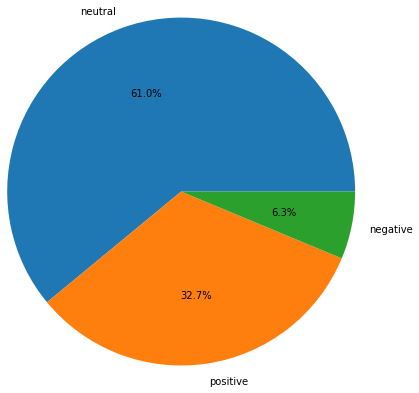

In [19]:
plt.pie(df_pie["sentiment"],labels=df_pie["index"],radius=2,autopct="%1.1f%%")
plt.show()

#### Out of 9065 sentiments:
 * 5528(61%) are Neutral sentiments
 * 2968(32.7%) are Positive sentiments
 * 569(6.3%) are Negative sentiments

#### Creating a new DataFrame To analyse products

In [20]:
#removing all NaN product values
df_prod=df[df["product"].notna()]

In [21]:
df_prod["product"].isna().sum()

0

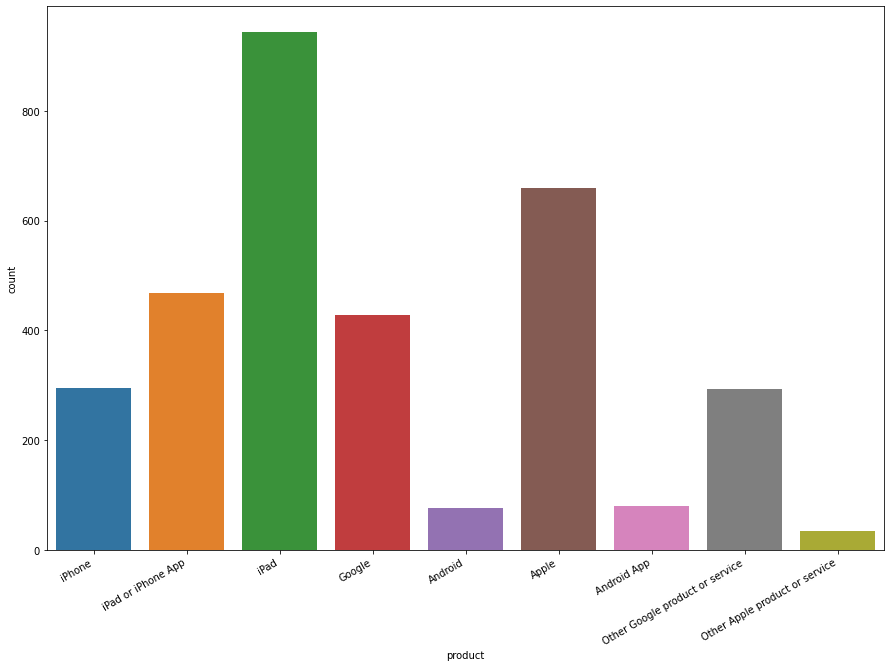

In [22]:
plt.subplots(figsize = (15,10))
chart=sns.countplot(x="product",data=df_prod);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

#### There are 9 types of products which are mentioned in the dataset. Out of all the products:
  * Ipad is the most tweeted about, followed by apple(company)
  * Android, Android app and Other Apple products and services are less tweeted about.
  

#### Products vs Sentiments

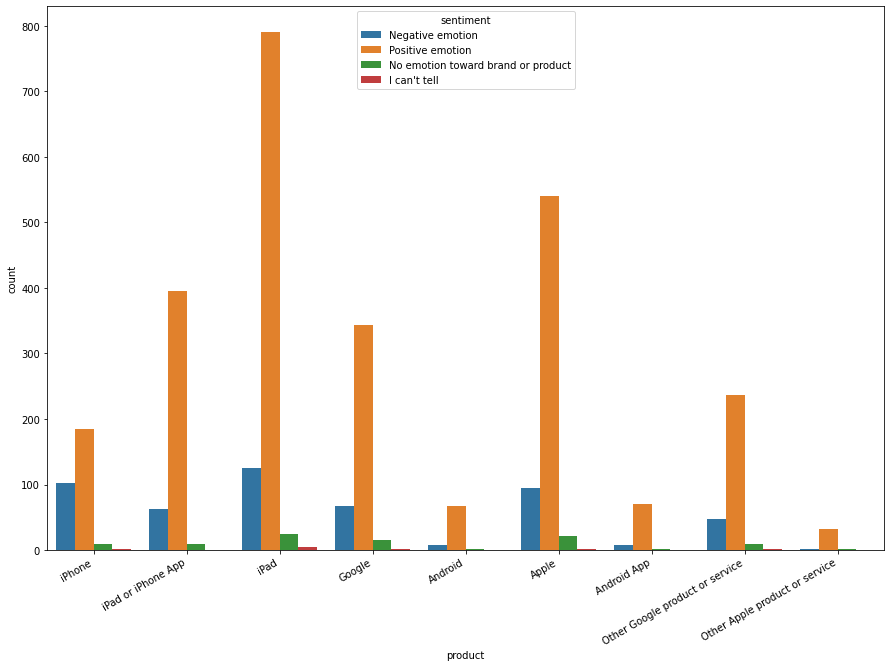

In [23]:
plt.subplots(figsize = (15,10))
chart=sns.countplot(x="product",hue="sentiment",data=df_prod);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

#### Of all the sentiments per product:
 * All the products mostly have positive reviews associated with them.
 * Iphone has has the highest proportions of negative sentiments of all products.
 * The neutral sentiment has a very small proportion in the entire data spread, which is contradictary to our original data. It means, that a lot of rows where product is NaN, the sentiment is neutral.
 

#### WordCloud

In [24]:
def create_wordcloud(text):
    words=' '.join([words for words in text])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

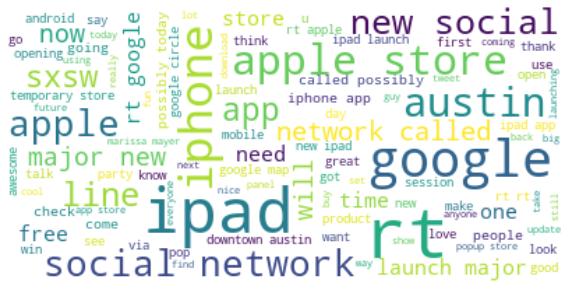

In [25]:
#wordcloud for all tweets
create_wordcloud(test1["tweet"].values)

#### The most common words across all tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Use, Today, Launch, Time,Network, Called etc.

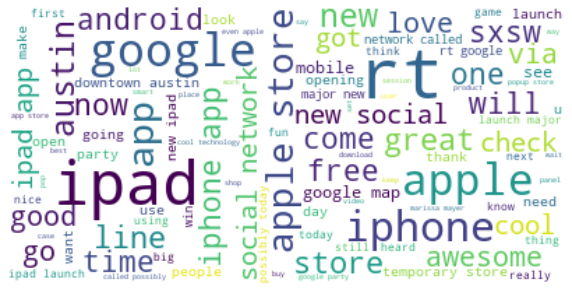

In [26]:
#wordcloud for all positive tweets
create_wordcloud(test1[test1["sentiment"]=="positive"]["tweet"].values)

#### The most common words across all Positive tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Nice, Great, Awesome, love, fun, cool etc.

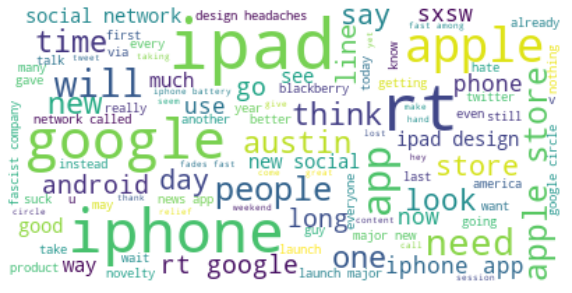

In [27]:
#wordcloud for all Negative tweets
create_wordcloud(test1[test1["sentiment"]=="negative"]["tweet"].values)

#### The most common words across all Negative tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Long, suck, Design, wait, hate etc.

#### Hashtags Analysis

In [28]:
df["sent_score"]=df["sentiment"].factorize()[0]
#for all tweets
tweets = df['tweet'].tolist()
len(tweets)

9065

#### Most Frequent  hashtags in positive tweets

In [29]:
#for all positive tweets
positive = df[df['sent_score']==1]
positive=positive.apply(lambda x:x.astype(str).str.lower())
positive_list = positive['tweet'].tolist() 
positive_sentences_to_string = ''.join(positive_list)
pos_hash = re.findall(r"#(\w+)",positive_sentences_to_string)
pos_freq = nltk.FreqDist(pos_hash)
pos_hash_df = pd.DataFrame({'hashtag': list(pos_freq.keys()),
                 'count': list(pos_freq.values())})
pos_hash_df=pos_hash_df.sort_values("count",ascending=False)[:10].reset_index()
pos_hash_df

,index,hashtag,count
0,0,sxsw,2207
1,22,apple,160
2,9,sxswrt,159
3,17,ipad2,107
4,1,ipad,87
5,28,sxswi,84
6,36,iphone,80
7,55,google,66
8,4,android,40
9,12,austin,37


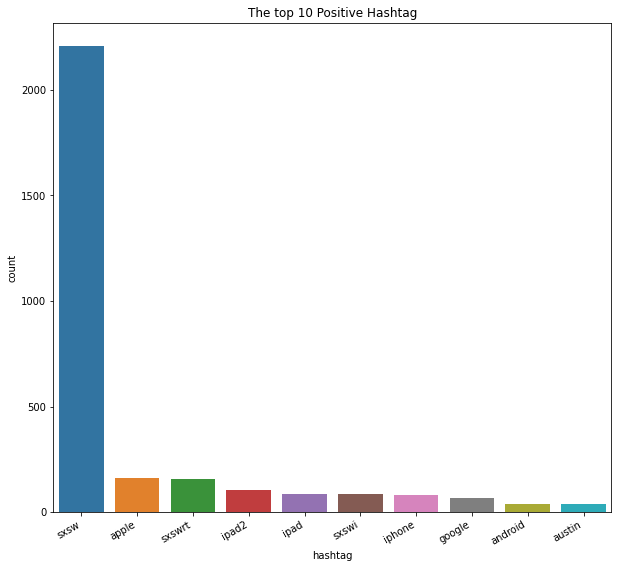

In [30]:
plt.subplots(figsize = (10,9))
plt.title("The top 10 Positive Hashtag")
chart=sns.barplot(x="hashtag",y="count",data=pos_hash_df);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

#### Most frequent hashtags in Negative Tweets

In [31]:
#for all positive tweets
negative = df[df['sent_score']==0]
negative=negative.apply(lambda x:x.astype(str).str.lower())
negative_list = negative['tweet'].tolist() 
negative_sentences_to_string = ''.join(negative_list)
neg_hash = re.findall(r"#(\w+)",negative_sentences_to_string)
neg_freq = nltk.FreqDist(neg_hash)
neg_hash_df = pd.DataFrame({'hashtag': list(neg_freq.keys()),
                 'count': list(neg_freq.values())})
neg_hash_df=neg_hash_df.sort_values("count",ascending=False)[:10].reset_index()
neg_hash_df

,index,hashtag,count
0,1,sxsw,351
1,219,sxswrt,51
2,32,ipad,18
3,2,sxswi,16
4,4,google,13
5,45,apple,12
6,3,iphone,12
7,70,tapworthy,11
8,68,fail,9
9,23,japan,9


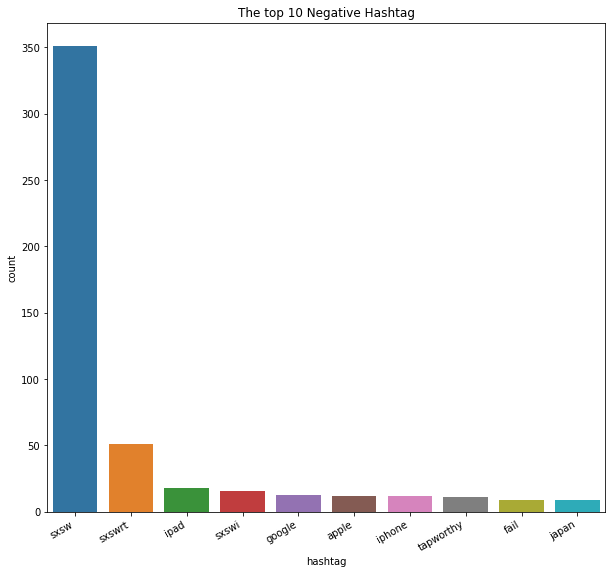

In [32]:
plt.subplots(figsize = (10,9))
plt.title("The top 10 Negative Hashtag")
chart=sns.barplot(x="hashtag",y="count",data=neg_hash_df);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');


## Data PreProcessing

Creating a new Label encoded column for sentiments

In [33]:
test1["sent_score"]=test1["sentiment"].factorize()[0]

In [34]:
test1.head()

,tweet,product,sentiment,length,sent_score
0,i have a iphone after hrs tweeting at it was d...,iphone,negative,86,0
1,know about awesome app that likely appreciate ...,ipad or iphone app,positive,78,1
2,can not wait for also they should sale them do...,ipad,positive,51,1
3,i hope this festival as crashy as this iphone app,ipad or iphone app,negative,49,0
4,great stuff on fri marissa mayer tim matt mull...,google,positive,51,1


In [35]:
test1["sent_score"].value_counts()

2    5528
1    2968
0     569
Name: sent_score, dtype: int64

Here 0=Negative, 1=Positive, 2=Neutral

In [36]:
#Dopping all neutral sentiments to generalize the model
test1=test1[test1["sentiment"]!="neutral"]

In [37]:
# Define our X and y
X = test1['tweet']
y = test1['sent_score']

# # Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF/IDF Features

In [38]:
tfidfconverter = TfidfVectorizer(min_df=3, sublinear_tf=True,norm="l2",encoding="latin-1", ngram_range=(1,2),stop_words='english')
X_train_features= tfidfconverter.fit_transform(X_train.reset_index()["tweet"]).toarray()

In [39]:
X_train_features.shape

(2829, 2087)

There are 2829 rows having 15643 features

In [40]:
sentiment_id_df =test1[['sentiment', 'sent_score']].drop_duplicates().sort_values('sent_score')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['sent_score', 'sentiment']].values)
print("sentiment_to_id: ",sentiment_to_id)
print("id_to_sentiment: ",id_to_sentiment)

sentiment_to_id:  {'negative': 0, 'positive': 1}
id_to_sentiment:  {0: 'negative', 1: 'positive'}


#### Using Count vectorizer to convert the words into a sequence of tokens and Feed it to a Naive Bayes algorithm to check its implementation

In [47]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.fit_transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
nb = MultinomialNB().fit(X_train_tfidf, y_train)

#### Running the data over various models to check which is best suited model for our data

In [43]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_features, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


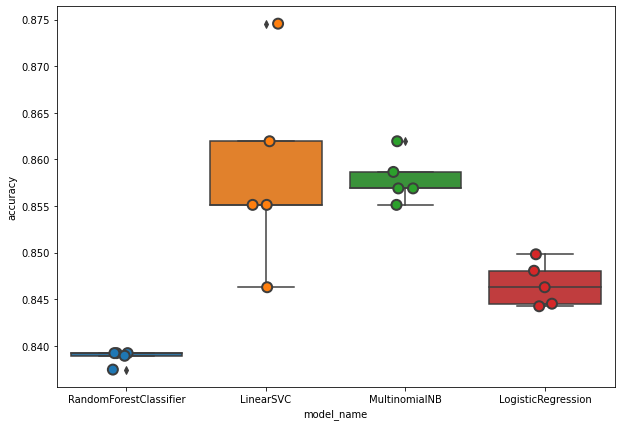

In [44]:
import seaborn as sns
plt.subplots(figsize = (10,7))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### From the above graph, it can be seen that the Linear SCV has the highest mean accuracy

In [45]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.858608
LogisticRegression        0.846588
MultinomialNB             0.857902
RandomForestClassifier    0.838812
Name: accuracy, dtype: float64

#### Hence, Implementing Linear SCV

In [68]:
model = LinearSVC()
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_train_features, y_train, test_size=0.2, random_state=0)
model.fit(X_train_v, y_train_v)
y_pred = model.predict(X_test_v)

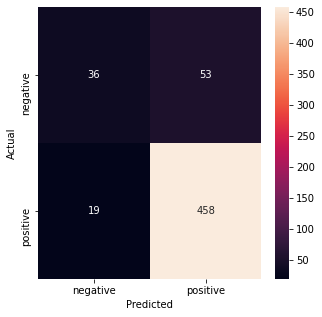

In [70]:
conf_mat = confusion_matrix(y_test_v, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sentiment_id_df.sentiment.values, yticklabels=sentiment_id_df.sentiment.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [71]:
print(metrics.classification_report(y_test_v, y_pred, target_names=test1['sentiment'].unique()))

              precision    recall  f1-score   support

    negative       0.65      0.40      0.50        89
    positive       0.90      0.96      0.93       477

    accuracy                           0.87       566
   macro avg       0.78      0.68      0.71       566
weighted avg       0.86      0.87      0.86       566



#### Implementing XGBoost

In [72]:
X_train_counts = count_vect.transform(X_train)
X_test_counts = count_vect.transform(X_test)

clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_counts, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train_counts)
test_preds = clf.predict(X_test_counts)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

[22:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\anaconda\envs\glm\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [75]:
print("Accuracy of XGBoost: ",test_accuracy)

Accuracy of XGBoost:  0.8742937853107344


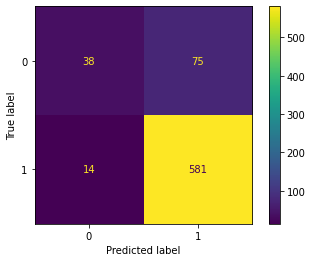

In [73]:
plot_confusion_matrix(clf, X_test_counts, y_test);

In [74]:
print(metrics.classification_report(y_test, test_preds, target_names=test1['sentiment'].unique()))

              precision    recall  f1-score   support

    negative       0.73      0.34      0.46       113
    positive       0.89      0.98      0.93       595

    accuracy                           0.87       708
   macro avg       0.81      0.66      0.69       708
weighted avg       0.86      0.87      0.85       708



### Metrics

#### F1 Score (F1)

$$\text{F1} = 2*\frac{\text{precision * recall}}{\text{precision + recall}} $$

$$\text{} = \frac{\text{TP}}{\text{TP+1/2(FP+FN)}} $$


F1 Score  is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.F1-score is a better choice of metric when there are imbalanced classes as in our case. It good F1 score shows that we have less False positives and False negatives.

### XGBoost VS Linear SVC

* The mean accuracy of Linear SVC is  85.86%
* The mean accuracy of XGBoost is  87.42%
* Although the accuracy of XGBoost is more, when we plot the confusion matrix, we can see that Linear SVC has a better F1 score than XGBoost for Negative Tweets
* As a result, it can identify the Negative tweets more accurately than XGBoost
* Hence, We choose, Linear SVC as our final model


## Feature Importance

In [84]:
# Referred the below link to plot Most important features(words) within the model
#https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d#:~:text=Once%20a%20linear%20SVM%20is,can%20be%20accessed%20with%20svm.&text=The%20absolute%20size%20of%20the,for%20the%20data%20separation%20task.

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

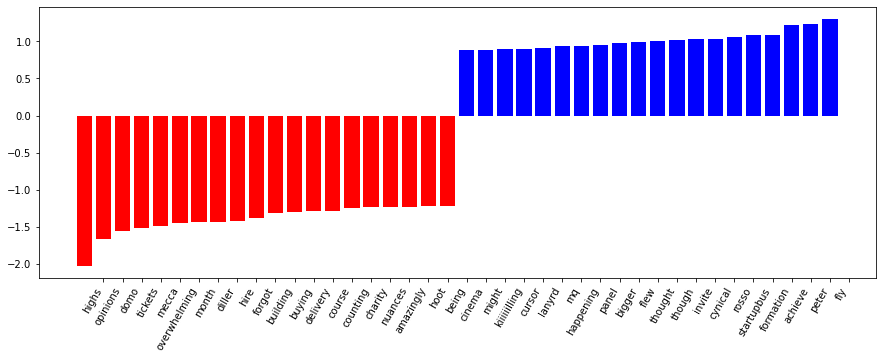

In [82]:
feature_names = count_vect.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
df_feat=pd.DataFrame(coefs_with_fns)
df_feat.columns='coefficient','word'
df_feat.sort_values(by='coefficient')

plot_coefficients(model, feature_names)

#### As you can see above, the plot provides useful insight into what features (words) are being used by the model to make the positive and negative classifications from a sentiment dataset

### Conclusions

### After exploring multiple classifying models through cross validation technique and vectorizing withTfdif, I found out:

 * we visualized our dataset and observed that there were more neutral sentiments as compared to positive and negative sentiments.
 * However,after dropping all the products which had NaN values,we observed that the neutral sentiment has a very small proportion in the entire data spread, which is contradictary to our original data. It means, that a lot of rows where product is NaN, the sentiment is neutral.
 * All the models perform better with Tfdif vectorizer.Tfdif gives us most frequently present n-grams(words) within our dataset that helps our model to understand the data more efficiently and map correlations.
 * The best performing model of the whole lot was LinearSVC. It gave us a mean accuracy of 85.86% with F1 score of 93% for positive tweets and 50% for negative tweets.
 * LinearSCV which works on the concept of hyperplanes helps us distinguish between positive and negative sentiments with a decent accuracy
 * Also, the most important features(words) in negative tweets were : highs, tickets, forgot, hoot, delivery etc.
 * The most important features(words) in positive tweets were : fly, achieve, formation, bigger, king etc.

### Future work
 * Add Neutral sentiments to the target variables along with Positive and Negative. strategies need to be implemented to balance the data.
 * Use of Embeddings.CBoW, Glove, or Bert embeddings can be used to cluster similar meaning words together. This will help to distinguish words between positive, negative and neutral sentiments thoroughly.
 * Use pre-trained models such as Bert or Transformer-5(T5) and check how they perform over the dataset.
 